In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam


### Load the data

In [ ]:
fake_news=pd.read_csv("ML KNN Overview Fake.txt", header=None)
true_news=pd.read_csv("ML KNN Overview Real.txt", header=None)

In [ ]:
fake_news

## Set the columns name 'text'

In [ ]:
fake_news.columns=['text']
true_news.columns=['text']

In [ ]:
true_news['label']=1
fake_news['label']=0

## Combine the dataset

In [ ]:
news_df=pd.concat([fake_news,true_news])

In [ ]:
# Shuffle the dataset
news_df = news_df.sample(frac=1).reset_index(drop=True)

In [ ]:

# Preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

news_df['text'] = news_df['text'].apply(preprocess_text)

## Spliting the data

In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(news_df['text'], news_df['label'], test_size=0.2, random_state=42)

## Vectorization

In [ ]:
vectorizer= TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define function to plot training history


In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],label='Training loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.show()

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_test,y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to evaluate models
def evaluate_model(model, X_trai,y_train,X_test,y_test):
    model.fit(X_trai,y_train)
    y_pred=model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:,1]
    
    accuracy=accuracy_score(y_test,y_pred)
    cm=confusion_matrix(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    
    print(f'Accuracy: {accuracy}')
    print('Confusion Matrix')
    print(cm)
    print(f'Report of Confusion Matrix')
    print(report)
    plot_roc_curve(y_test,y_pred_prob)

## Logistic Regression 

In [ ]:
print("Logistic Regression")
logreg=LogisticRegression(max_iter=1000)
evaluate_model(logreg,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Multinomial Naive Bayes

In [ ]:
print("Multinomial Naive Bayes")
mnb=MultinomialNB()
evaluate_model(mnb,X_train_tfidf,y_train,X_test_tfidf,y_test)


## Support Vector Machine

In [ ]:
print("Support Vector Machine")
svc=SVC(probability=True)
evaluate_model(svc,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Random Forest

In [ ]:
print("Random Forest")
rf=RandomForestClassifier(n_estimators=100)
evaluate_model(rf,X_train_tfidf,y_train,X_test_tfidf,y_test)

## Neural Network

In [ ]:
print("Neural Network")
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(512,input_dim=input_dim,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
    return model

nn_model=create_nn_model(X_train_tfidf.shape[1])
history=History()
nn_model.fit(X_train_tfidf.toarray(),y_train,epochs=10, batch_size=128,validation_split=0.2,callbacks=[history])
plot_history(history)

# Evaluate Neural Network

y_pred_prob_nn=nn_model.predict(X_test_tfidf.toarray()).ravel()
y_pred_nn=(y_pred_prob_nn>0.5).astype(int)
print(f'Accuracy: {accuracy_score(y_test,y_pred_nn)}')
print(f'Confusion Matrix: {confusion_matrix(y_test,y_pred_nn)}')
print(f'Classification Report: {classification_report(y_test,y_pred_nn)}')
plot_roc_curve(y_test,y_pred_prob_nn)

In [ ]:
# Compare models
results=pd.DataFrame(
    {
        'Model':['Logistic Regression','Multinomial Naive Bayes','Support Vector Machine','Random Forest','Neural Network'],
        'Accuracy':[accuracy_score(y_test, logreg.predict(X_test_tfidf)),
                    accuracy_score(y_test, mnb.predict(X_test_tfidf)),
                    accuracy_score(y_test, svc.predict(X_test_tfidf)),
                    accuracy_score(y_test, rf.predict(X_test_tfidf)),
                    accuracy_score(y_test, y_pred_nn)]
    }
)
print(results)

Training a neural network model to detect fake news:

### 1. Data loading and preprocessing

- **Load data:** Collect a dataset containing true and false articles, and label them (e.g. "true" or "false").
- **Data pre-processing:**
- Convert text to lower case for uniformity.
- Remove punctuation and numbers to clean data.

### 2. Data decomposition and vectorization

- **Split data:** Use function `train_test_split` to split data into training set and test set.
- **Vectorization:** Use TF-IDF method to convert text data into digital features (digital vector).

### 3. Identify and train the neural network model

- **Determine model:**
- Create a simple neural network model with two fully connected layers (Dense layers) and a Dropout layer to prevent overfitting.
- **Model training:**
- Use training data to train the model.
- Record changes in loss and accuracy during training.

### 4. Plot the training history

- **Plot:** Use the `plot_history` function to plot the change in precision and loss for both the training and validation sets.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam

In [ ]:
fake_news=pd.read_csv('ML KNN Overview Fake.txt',header=None)
true_news=pd.read_csv('ML KNN Overview Real.txt',header=None)

In [ ]:
# Set col names
fake_news.columns=['text']
true_news.columns=['text']
# Add labels
true_news['label']=1
fake_news['label']=0

In [ ]:
news_df=pd.concat([true_news,fake_news])

In [ ]:
news_df

In [ ]:
# Shuffle the dataset
news_df=news_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Preprocess text
def preprocess_text(text):
    # Lower text
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

news_df['text'] = news_df['text'].apply(preprocess_text)

# Split data
X_train,X_test,y_train,y_test=train_test_split(news_df['text'],news_df['label'],test_size=0.2,random_state=42)

In [ ]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Create a neural network model

Epoch 1/10


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5518 - loss: 0.6841 - val_accuracy: 0.6138 - val_loss: 0.6425
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6020 - loss: 0.6192 - val_accuracy: 0.7342 - val_loss: 0.5315
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8713 - loss: 0.4119 - val_accuracy: 0.8298 - val_loss: 0.3627
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9597 - loss: 0.1649 - val_accuracy: 0.8356 - val_loss: 0.3563
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9790 - loss: 0.0752 - val_accuracy: 0.8432 - val_loss: 0.3808
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9916 - loss: 0.0300 - val_accuracy: 0.8356 - val_loss: 0.4161
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9991 - loss: 0.0136 - val_accuracy: 0.8356 - val_loss: 0.4372
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.8375 - val_loss: 0.

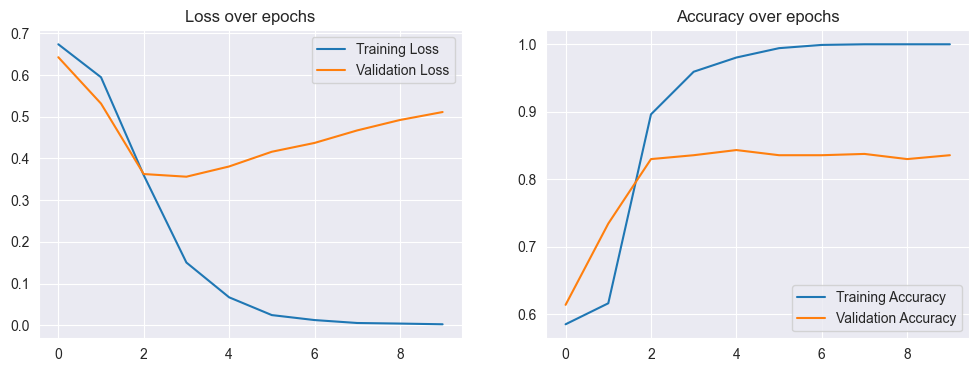

In [86]:
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

nn_model=create_nn_model(X_train_tfidf.shape[1])
history=History()
# Fit the model
nn_model.fit(X_train_tfidf.toarray(),y_train,epochs=10, batch_size=128,validation_split=0.2,callbacks=[history])

# Plotting
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.show()

plot_history(history)


## Discuss the results
1. Loss curve
It can be seen from the Loss Curve of the training and validation sets:

- Training loss: Usually continues to decrease, showing that the model is getting better and better on the training set.
- Validation loss: If the validation loss also decreases and is close to the training loss, it means the model has better generalization ability. If the validation loss starts to increase during training, it could be a sign that the model is starting to overfit.
If during training it is observed that the training loss continues to decrease while the validation loss starts increasing after a certain point then this is a typical sign of Overfitting. Overfitting can be minimized by adjusting model complexity, adding regularity, or using more skip layers.

2. Precise curves
It can be seen from the Accuracy Curve of the training and validation sets:

- Training accuracy: Usually continues to increase, indicating the model is performing better and better on the training set.
- Validation accuracy: If the validation accuracy also increases and is close to the training accuracy, it means the model has better generalization ability. If validation accuracy starts to decrease, it means the model is starting to overfit.
I would like to see both training and validation accuracy increase and eventually level off. If the verification accuracy is significantly lower than the training accuracy then that also indicates an Overfitting problem.

In [89]:
def output_label(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"